In [ ]:
## Ues For intal Processor 
# !pip install -r requirements.txt
## Use requirements_silicon.txt for silicon Processor (M1,M2,M3 ,ect..)
# !pip install -r requirements_silicon.txt

In [55]:
import os
import kagglehub
import zipfile
import json
import glob
import numpy as np
from collections import Counter
import rasterio
import tensorflow as tf
import tifffile as tiff
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, Model
from collections import Counter
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
# Constants
BASE_DIR = "../data/"
class_mapping = {
    1: 'Marine Debris',
    2: 'Dense Sargassum',
    3: 'Sparse Sargassum',
    4: 'Natural Organic Material',
    5: 'Ship',
    6: 'Clouds',
    7: 'Marine Water',
    8: 'Sediment-Laden Water',
    9: 'Foam',
    10: 'Turbid Water',
    11: 'Shallow Water',
    12: 'Waves',
    13: 'Cloud Shadows',
    14: 'Wakes',
    15: 'Mixed Water'
}
color_mapping = {
    1: (255, 0, 0),      # Marine Debris - Red
    2: (0, 128, 0),      # Dense Sargassum - Green
    3: (144, 238, 144),  # Sparse Sargassum - Light Green
    4: (139, 69, 19),    # Natural Organic Material - Brown
    5: (128, 128, 128),  # Ship - Gray
    6: (255, 255, 255),  # Clouds - White
    7: (0, 0, 255),      # Marine Water - Blue
    8: (210, 180, 140),  # Sediment-Laden Water - Tan
    9: (255, 255, 224),  # Foam - Light Yellow
    10: (64, 224, 208),  # Turbid Water - Turquoise
    11: (176, 224, 230), # Shallow Water - Powder Blue
    12: (0, 191, 255),   # Waves - Deep Sky Blue
    13: (105, 105, 105), # Cloud Shadows - Dim Gray
    14: (220, 220, 220), # Wakes - Gainsboro
    15: (70, 130, 180)   # Mixed Water - Steel Blue
}
class_mapping_confidence = {
    1: 'High',
    2: 'Moderate',
    3: 'Low',
}

# Dataset Download & Extraction:

In [59]:
def download_and_extract_dataset():
    print("Downloading MARIDA dataset from Kaggle...")
    dataset_path = kagglehub.dataset_download("anangfath/marida-marine-debrish-dataset")
    print(f"Path to dataset files: {dataset_path}")
    
    if os.path.exists(f"{BASE_DIR}MARIDA.zip"):
        print("Extracting MARIDA dataset...")
        with zipfile.ZipFile(f"{BASE_DIR}MARIDA.zip", 'r') as zip_ref:
            zip_ref.extractall(BASE_DIR)
        print("Dataset extracted!")
    return dataset_path

# Create directory for storing processed files
def create_directory(path):
    # PROCESSED_DIR = os.path.join(BASE_DIR)
    if not os.path.exists(path):
        os.makedirs(path)

# Function to get image and mask paths
def get_image_and_mask_paths(dataset_path):
    # Print the absolute path for debugging
    patches_dir=f"{dataset_path}/patches/"
    print(f"Looking for patches in directory: {os.path.abspath(patches_dir)}")
    image_paths = []
    mask_paths = []
    confidence_paths = [] 

    for subfolder in os.listdir(patches_dir):
        subfolder_path = os.path.join(patches_dir, subfolder)
        if os.path.isdir(subfolder_path):
            images = sorted(glob.glob(os.path.join(subfolder_path, "*.tif")))
            for img_path in images:
                if "_cl.tif" in img_path or "_conf.tif" in img_path:
                    continue
                
                mask_path = img_path.replace(".tif", "_cl.tif")
                cof_path = img_path.replace(".tif", "_conf.tif")  # Confidence mask path

                if os.path.exists(mask_path) and os.path.exists(cof_path):
                    image_paths.append(img_path)
                    mask_paths.append(mask_path)
                    confidence_paths.append(cof_path)  
    
    return image_paths, mask_paths, confidence_paths

# Function to split and save data into train, validation, and test sets
def split_and_save_data(image_paths, mask_paths,confidence_paths):
    train_imgs, temp_imgs, train_masks, temp_masks, train_confidence, temp_confidence = train_test_split(
            image_paths, mask_paths, confidence_paths, test_size=0.2, random_state=42
        )
    val_imgs, test_imgs, val_masks, test_masks, val_confidence, test_confidence = train_test_split(
            temp_imgs, temp_masks, temp_confidence, test_size=0.5, random_state=42
        )
    print(f"📊 Dataset Split: Train={len(train_imgs)}, Val={len(val_imgs)}, Test={len(test_imgs)}")

    # Save paths to text files
    splits_dir = f"{BASE_DIR}splits/"
    os.makedirs(splits_dir, exist_ok=True)
    
    def save_paths(file_path, paths):
        with open(file_path, "w") as f:
            for path in paths:
                f.write(os.path.abspath(path) + "\n")

    
    save_paths(f"{splits_dir}train_X.txt", train_imgs)
    save_paths(f"{splits_dir}val_X.txt", val_imgs)
    save_paths(f"{splits_dir}test_X.txt", test_imgs)
    
    save_paths(f"{splits_dir}train_masks.txt", train_masks)
    save_paths(f"{splits_dir}val_masks.txt", val_masks)
    save_paths(f"{splits_dir}test_masks.txt", test_masks)
    
    save_paths(f"{splits_dir}train_confidence.txt", train_confidence)
    save_paths(f"{splits_dir}val_confidence.txt", val_confidence)
    save_paths(f"{splits_dir}test_confidence.txt", test_confidence)

    print("✅ Successfully split data into train, validation, and test sets with confidence masks!")

# Load the label mapping from a JSON file    
def load_labels(file_path):
    with open(file_path, "r") as f:
        label_mapping = json.load(f)
    return label_mapping


def main():
    dataset_path = download_and_extract_dataset()
    create_directory(BASE_DIR)
    image_paths, mask_paths, confidence_paths = get_image_and_mask_paths(dataset_path)
    split_and_save_data(image_paths, mask_paths, confidence_paths)

    label_mapping = load_labels(f"{dataset_path}/labels_mapping.txt")
    print("Labels loaded successfully.")

if __name__ == "__main__":
    main()

Path to dataset files: /Users/nouri/.cache/kagglehub/datasets/anangfath/marida-marine-debrish-dataset/versions/1
Looking for patches in directory: /Users/nouri/.cache/kagglehub/datasets/anangfath/marida-marine-debrish-dataset/versions/1/patches
📊 Dataset Split: Train=1104, Val=138, Test=139
✅ Successfully split data into train, validation, and test sets with confidence masks!
Labels loaded successfully.


# preprocessing

In [ ]:
    
# Image preprocessing pipeline
def normalize_band(band):
    """Normalizes a single band using the 2nd and 98th percentile."""
    min_val, max_val = np.percentile(band, (2, 98))  # Normalize between 2nd and 98th percentiles
    normalized_band = np.clip((band - min_val) / (max_val - min_val), 0, 1)
    return normalized_band

# Preprocess image bands (Blue, Green, Red, NIR, SWIR1)
def pre_processing_band_images(image_path):
    """Preprocesses satellite image bands and computes multiple indices."""
    with rasterio.open(image_path) as src:
        blue = src.read(2)   # Blue (B2)
        green = src.read(3)  # Green (B3)
        red = src.read(4)    # Red (B4)
        nir = src.read(8)    # NIR (B8)
        swir1 = src.read(11) # SWIR1 (B11)

    blue_norm = normalize_band(blue)
    green_norm = normalize_band(green)
    red_norm = normalize_band(red)
    nir_norm = normalize_band(nir)
    swir1_norm = normalize_band(swir1)
    
    epsilon = 1e-6  # Small constant to avoid division by zero
    # 1. NDVI - Normalized Difference Vegetation Index
    ndvi = (nir_norm - red_norm) / (nir_norm + red_norm + epsilon)
    # 2. NDWI - Normalized Difference Water Index (McFeeters)
    ndwi = (green_norm - swir1_norm) / (green_norm + swir1_norm + epsilon)
    # 4. AWEI - Automated Water Extraction Index
    awei = ( green_norm + 2.5 * swir1_norm) - (1.25 * nir_norm - 0.25 * blue_norm)
    # 5. FDI - Floating Debris Index
    fdi = nir_norm - (red_norm + swir1_norm) / 2.0
    # 6. PPI - Plastic Presence Index (Custom Index)
    ppi = (blue_norm - nir_norm) / (blue_norm + nir_norm + epsilon)  # Similar to NDPI, customized ??
    # 7. PFDI - Plastic Floating Debris Index (Best Index for Floating Plastic)
    pfdi= (swir1_norm - nir_norm) / (swir1_norm + nir_norm + red_norm + epsilon)
    
    rgb_image = np.stack([red_norm, green_norm, blue_norm], axis=-1)
    n_s_b_image = np.stack([nir_norm, swir1_norm, blue_norm], axis=-1)

    return {
            'blue_norm': blue_norm,
            'green_norm': green_norm,
            'red_norm': red_norm,
            'nir_norm': nir_norm,
            'swir1_norm': swir1_norm,
            'ndvi': ndvi,
            'ndwi': ndwi,
            'awei':awei,
            'fdi': fdi,
            'ppi': ppi,
            'pfdi': pfdi,  # Plastic Floating Debris Index
            'rgb_image':rgb_image,
            'n_s_b_image':n_s_b_image    
        }
     

    

# Visualization

In [90]:
# Function to convert mask values to RGB and map it with the classes 
def apply_color_mapping(mask_path,conf_path, color_mapping):
    """Applies color mapping to a given mask and confidence file."""
    with rasterio.open(mask_path) as mask_src , rasterio.open(conf_path) as conf_src:
        mask = mask_src.read(1)  # Read single-channel mask
        conf = conf_src.read(1)  # Read single-channel mask
    
        h_mask, w_mask = mask.shape
        rgb_mask = np.zeros((h_mask, w_mask, 3), dtype=np.uint8)
        
        h_conf, w_conf = conf.shape
        rgb_conf = np.zeros((h_conf, w_conf, 3), dtype=np.uint8)
        
        for value, color in color_mapping.items():
            rgb_mask[mask == value] = color  # Apply color mapping
            rgb_conf[conf == value] = color  # Apply color mapping
        
        return {'rgb_mask':rgb_mask ,'original_mask':mask,'rgb_confidence':rgb_conf,'confidence':conf}
   
# Function to visualize the mask with legend
def Visualization(pre_processing_band,class_mapping,class_mapping_confidence,color_maping_fun):
    
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))

    ax[0,0].imshow(pre_processing_band['blue_norm'], cmap='Blues')
    ax[0,0].set_title("Blue Band (B2)")
    ax[0,0].axis("off")

    ax[0,1].imshow(pre_processing_band['nir_norm'], cmap='Reds')
    ax[0,1].set_title("NIR Band (B8)")
    ax[0,1].axis("off")

    ax[0,2].imshow(pre_processing_band['swir1_norm'], cmap='Purples')
    ax[0,2].set_title("SWIR1 Band (B11)")
    ax[0,2].axis("off")
    
    ax[0,3].imshow(pre_processing_band['ndvi'], cmap='Purples')
    ax[0,3].set_title("NDVI")
    ax[0,3].axis("off")

    ax[1,0].imshow(pre_processing_band['ndwi'], cmap='viridis')
    ax[1,0].set_title('NDWI')
    ax[1,0].axis('off')

    ax[1,1].imshow(pre_processing_band['awei'], cmap='viridis')
    ax[1,1].set_title('AWEI')
    ax[1,1].axis('off')

    ax[1,2].imshow(pre_processing_band['ppi'], cmap='viridis')
    ax[1,2].set_title('PPI')
    ax[1,2].axis('off')
    
    ax[1,3].imshow(pre_processing_band['pfdi'], cmap='viridis')
    ax[1,3].set_title('PFDI')
    ax[1,3].axis('off')
   

    fig, axes = plt.subplots(1, 4, figsize=(20, 10))

    axes[0].imshow(pre_processing_band['n_s_b_image'])
    axes[0].set_title(" Image (NIR, SWIR1, Blue)")
    axes[0].axis("off")

    axes[1].imshow(pre_processing_band['rgb_image'])
    axes[1].set_title("RGB Image")
    axes[1].axis("off")
    
    # Plot the mask
    axes[2].imshow(color_maping_fun['rgb_mask'])
    axes[2].set_title("Mask with Class Labels")
    axes[2].axis('off')
    #  # Create legend patches
    patches = [mpatches.Patch(color=np.array(color)/255, label=class_mapping[val]) 
                for val, color in color_mapping.items() if val in np.unique(color_maping_fun['original_mask'])]
    axes[2].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.3, -0.2),ncol=5, fontsize=8, frameon=False) # loc='upper right'
    
    #Conf
    axes[3].imshow(color_maping_fun['rgb_confidence'])
    axes[3].set_title("confidence Image")
    axes[3].axis("off")
         # Create legend patches
    patches = [mpatches.Patch(color=np.array(color)/255, label=class_mapping_confidence[val]) 
                for val, color in color_mapping.items() if val in np.unique(color_maping_fun['confidence'])]
    axes[3].legend(handles=patches, loc='lower center', bbox_to_anchor=(0.7, -0.2),ncol=5, fontsize=8, frameon=False) # loc='upper right'


    plt.show()
    
    mask_unique_values = np.unique(color_maping_fun['original_mask'])  # Get unique values
    conf_unique_values = np.unique(color_maping_fun['confidence'])  # Get unique values
    
    print(f"RGB Image Shape: {pre_processing_band['rgb_image'].shape}\n")
    print(f"Mask Shape: {color_maping_fun['original_mask'].shape}")
    print(f"Mask Unique values: {mask_unique_values}")
    print(f"Confidence Shape: {color_maping_fun['confidence'].shape}")
    print(f"Confidence Unique values: {conf_unique_values}")  
    
    

In [92]:
def process_images(image_file_path, mask_file_path, conf_file_path, num_images=1):
    """
    Reads image, mask, and confidence paths from text files and processes them.

    Parameters:
    - image_file_path (str): Path to the text file containing image file paths.
    - mask_file_path (str): Path to the text file containing mask file paths.
    - conf_file_path (str): Path to the text file containing confidence file paths.
    - num_images (int): Number of images to process (default is 7).
    """
    try:
        with open(image_file_path, "r") as image_file, \
             open(mask_file_path, "r") as mask_file, \
             open(conf_file_path, "r") as conf_file:

            # Iterate over the lines in all files simultaneously
            for i, (image_line, mask_line, conf_line) in enumerate(zip(image_file, mask_file, conf_file)):
                if i >= num_images:  # Stop after reading the specified number of images
                    break
                
                image_path = image_line.strip()  # Get the image path
                mask_path = mask_line.strip()    # Get the mask path
                conf_path = conf_line.strip()    # Get the confidence path

                print(f"Processing: {image_path}")

                # Check if mask and confidence files exist before proceeding
                if not os.path.exists(mask_path) or not os.path.exists(conf_path):
                    print(f"Warning: Missing mask or confidence file for {image_path}")
                    continue  # Skip this image if files are missing

                # Process Image
                pre_processing_band = pre_processing_band_images(image_path)
                color_mapping_result = apply_color_mapping(mask_path, conf_path, color_mapping)

                # Visualize Results
                Visualization(pre_processing_band, class_mapping, class_mapping_confidence, color_mapping_result)

    except Exception as e:
        print(f"Error: {e}")

Processing: /Users/nouri/.cache/kagglehub/datasets/anangfath/marida-marine-debrish-dataset/versions/1/patches/S2_24-4-19_36JUN/S2_24-4-19_36JUN_7.tif


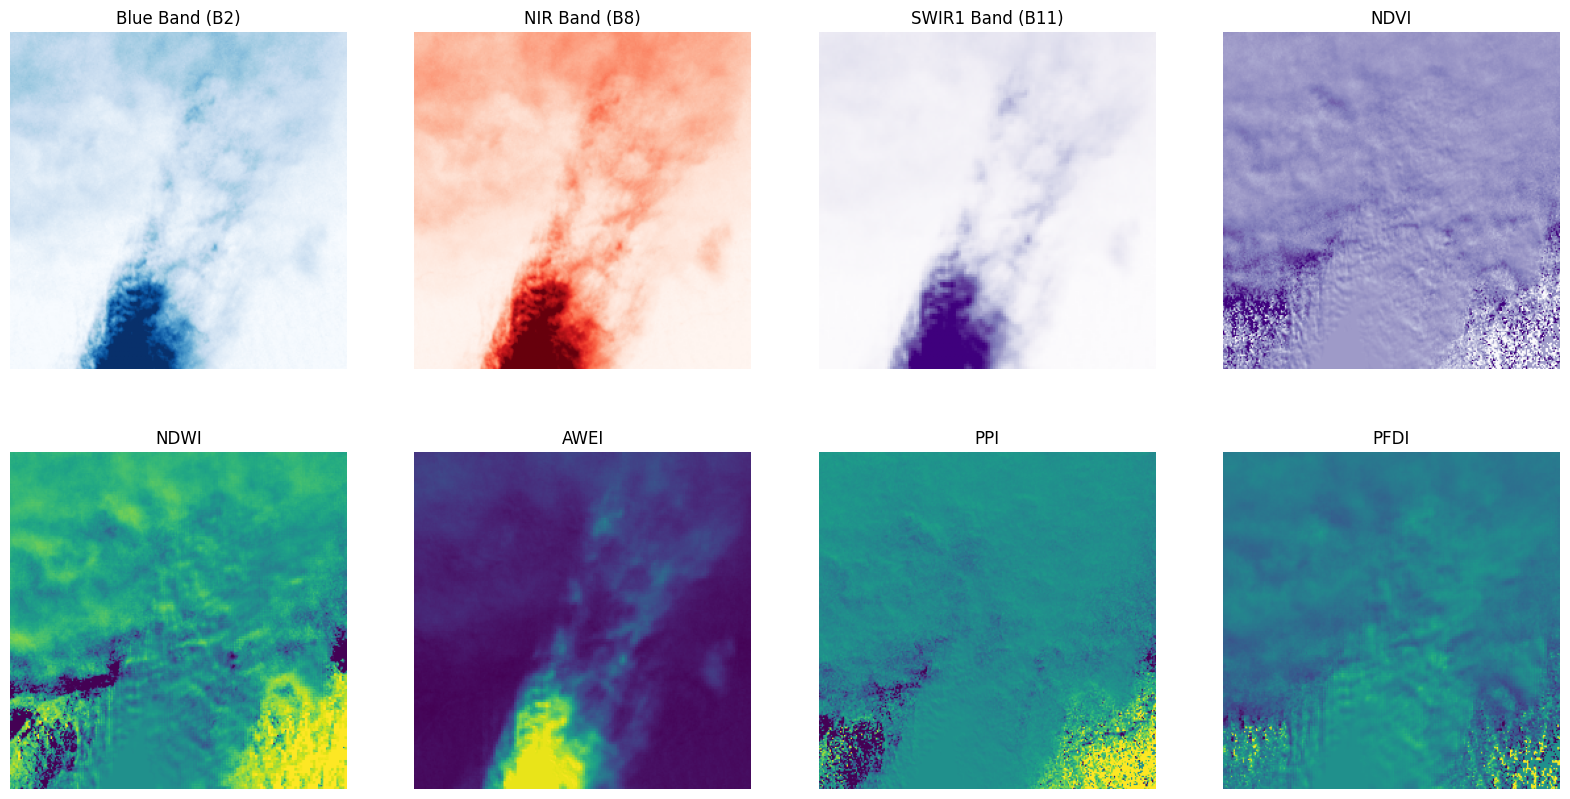

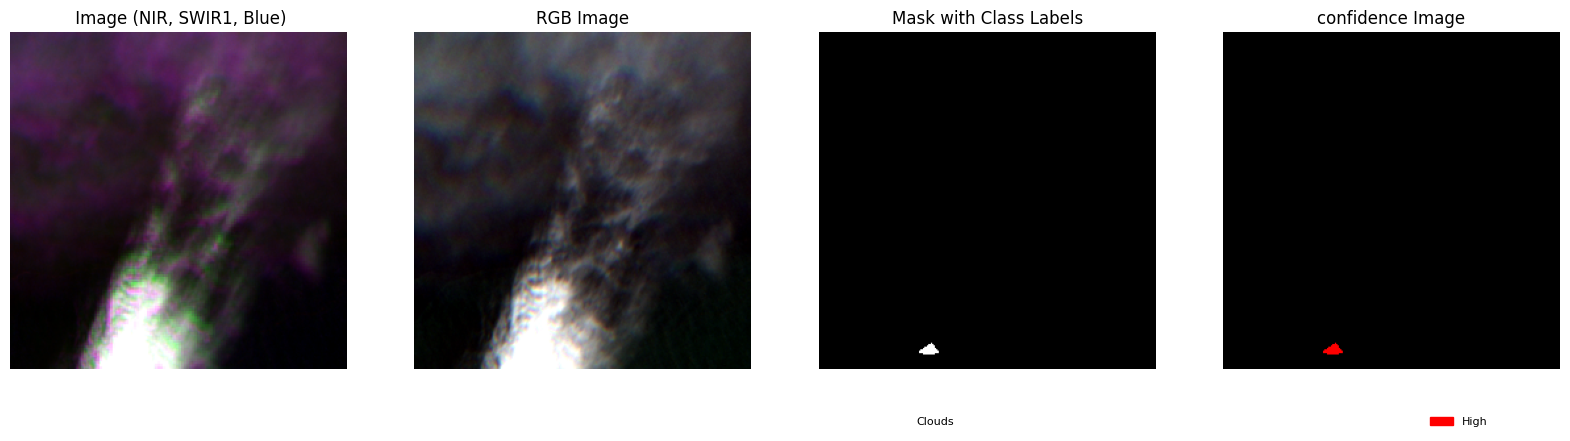

RGB Image Shape: (256, 256, 3)

Mask Shape: (256, 256)
Mask Unique values: [0. 6.]
Confidence Shape: (256, 256)
Confidence Unique values: [0. 1.]
Processing: /Users/nouri/.cache/kagglehub/datasets/anangfath/marida-marine-debrish-dataset/versions/1/patches/S2_7-10-18_52SDD/S2_7-10-18_52SDD_8.tif


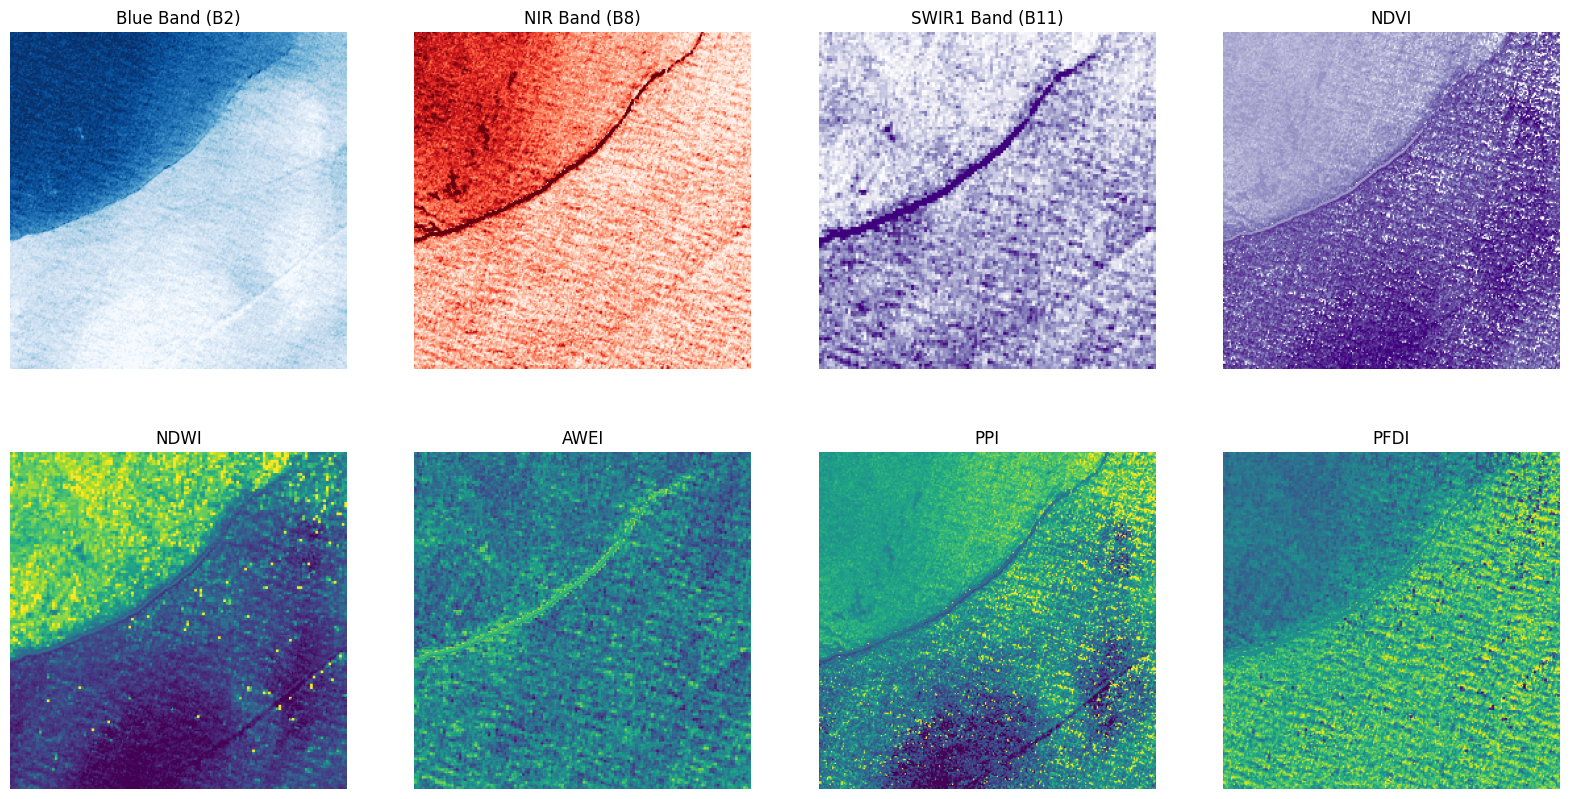

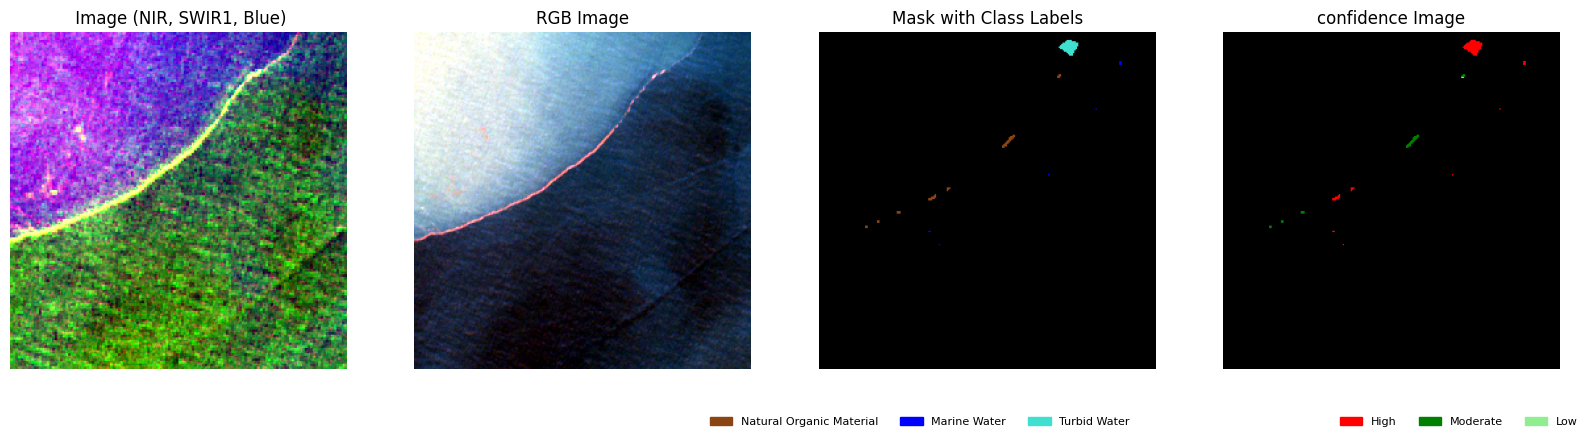

RGB Image Shape: (256, 256, 3)

Mask Shape: (256, 256)
Mask Unique values: [ 0.  4.  7. 10.]
Confidence Shape: (256, 256)
Confidence Unique values: [0. 1. 2. 3.]


In [ ]:
process_images(
    image_file_path="../NONO/splits/train_X.txt",
    mask_file_path="../NONO/splits/train_masks.txt",
    conf_file_path="../NONO/splits/train_confidence.txt",
    num_images=6  # Change this number to process more or fewer images
)


# Deep Learning Pipeline

In [97]:
# Constants
IMG_SIZE = (256, 256)
NUM_CHANNELS = 3  # Using 3 selected bands  
NUM_CLASSES = 15  
BATCH_SIZE = 16
EPOCHS = 30

In [98]:
# Function to Read file paths
def load_paths(file_path):
    with open(file_path, "r") as f:
        return [os.path.abspath(line.strip()) for line in f.readlines()]
 
 # Function to preprocess images
def load_image(image_path, mask_path):
    image_path, mask_path = image_path.decode("utf-8"), mask_path.decode("utf-8")
    pre_processing_band = pre_processing_band_images(image_path)
    image = np.stack([pre_processing_band['blue_norm'], pre_processing_band['nir_norm'], pre_processing_band['swir1_norm']], axis=-1)
    mask = tiff.imread(mask_path).astype(np.float32)
    mask = np.clip(mask - 1, 0, NUM_CLASSES - 1).astype(np.int32)  # Convert to (0-14)
    mask_one_hot = np.eye(NUM_CLASSES, dtype=np.float32)[mask]  # One-hot encoding
    return image, mask_one_hot

# Function to Create TensorFlow dataset
def create_tf_dataset(image_paths, mask_paths):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
    def _load_data(img_path, mask_path):
        img, mask = tf.numpy_function(load_image, [img_path, mask_path], [tf.float32, tf.float32])
        mask.set_shape((*IMG_SIZE, NUM_CLASSES))
        return img, mask
    return dataset.map(_load_data, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Function to compute class weights
def compute_class_weights(dataset):
    all_labels = []
    for _, mask in dataset:
        mask_np = mask.numpy().argmax(axis=-1).flatten()
        all_labels.extend(mask_np)
    class_counts = Counter(all_labels)
    total_pixels = sum(class_counts.values())
    class_weights = {cls: total_pixels / (len(class_counts) * count) for cls, count in class_counts.items()}
    return class_weights

# Load dataset paths
train_imgs, train_masks = load_paths("../data/splits/train_X.txt"), load_paths("../data/splits/train_masks.txt")
val_imgs, val_masks = load_paths("../data/splits/val_X.txt"), load_paths("../data/splits/val_masks.txt")
test_imgs, test_masks = load_paths("../data/splits/test_X.txt"), load_paths("../data/splits/test_masks.txt")

# Create datasets
train_dataset, val_dataset, test_dataset = create_tf_dataset(train_imgs, train_masks), create_tf_dataset(val_imgs, val_masks), create_tf_dataset(test_imgs, test_masks)
print("✅ Dataset Loaded!")

# Compute class weights
class_weights = compute_class_weights(train_dataset)
# Convert weights to tensor
class_weights_array = np.array([class_weights[i] for i in range(NUM_CLASSES)])



2025-04-01 18:10:18.871897: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-04-01 18:10:18.871921: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-04-01 18:10:18.871933: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-04-01 18:10:18.871958: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-01 18:10:18.871972: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


✅ Dataset Loaded!


In [99]:
# Custom weighted loss function
def weighted_categorical_crossentropy(y_true, y_pred):
    return CategoricalCrossentropy()(y_true, y_pred) * tf.reduce_sum(y_true * class_weights_array, axis=-1)

def unet_model(input_size=(256, 256, NUM_CHANNELS)):
    inputs = layers.Input(input_size)
    
    def conv_block(x, filters):
        x = layers.Conv2D(filters, (3, 3), activation="relu", padding="same")(x)
        x = layers.Conv2D(filters, (3, 3), activation="relu", padding="same")(x)
        return x
    
    def upsample_block(x, skip, filters):
        x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding="same")(x)
        x = layers.concatenate([x, skip])
        return conv_block(x, filters)
    
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)
    
    c5 = conv_block(p4, 1024)
    
    u6 = upsample_block(c5, c4, 512)
    u7 = upsample_block(u6, c3, 256)
    u8 = upsample_block(u7, c2, 128)
    u9 = upsample_block(u8, c1, 64)
    
    outputs = layers.Conv2D(NUM_CLASSES, (1, 1), activation="softmax")(u9)
    return Model(inputs, outputs)

In [ ]:
# Compile and train the model
model = unet_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, clipvalue=1.0), loss=weighted_categorical_crossentropy, metrics=["accuracy"])
model.summary()

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS, callbacks=[callback])

test_loss, test_acc = model.evaluate(test_dataset)
print(f"📝 Test Accuracy: {test_acc * 100:.2f}%")

model.save("../models/unet_plastic_segmentation.h5")
print("✅ Training Complete!")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

2025-04-01 18:10:38.708206: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-01 18:10:38.847855: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


69/69 [==============================] - 85s 1s/step - loss: 2.6596 - accuracy: 0.3266 - val_loss: 2.8223 - val_accuracy: 0.8711
Epoch 2/30
69/69 [==============================] - 80s 1s/step - loss: 0.7640 - accuracy: 0.9663 - val_loss: 0.3403 - val_accuracy: 0.9908
Epoch 3/30
69/69 [==============================] - 81s 1s/step - loss: 0.2873 - accuracy: 0.9897 - val_loss: 0.2437 - val_accuracy: 0.9924
Epoch 4/30
69/69 [==============================] - 81s 1s/step - loss: 0.2329 - accuracy: 0.9903 - val_loss: 0.1845 - val_accuracy: 0.9924
Epoch 5/30
69/69 [==============================] - 79s 1s/step - loss: 0.1801 - accuracy: 0.9903 - val_loss: 0.1417 - val_accuracy: 0.9925
Epoch 6/30
69/69 [==============================] - 78s 1s/step - loss: 0.1414 - accuracy: 0.9903 - val_loss: 0.1210 - val_accuracy: 0.9925
Epoch 7/30
69/69 [==============================] - 78s 1s/step - loss: 0.1204 - accuracy: 0.9903 - val_loss: 0.1094 - val_accuracy: 0.9925
Epoch 8/30
69/69 [=============

In [ ]:
# Testing the model
sample_img, sample_mask = next(iter(train_dataset))
pred_mask = model.predict(sample_img)
print(pred_mask.shape)  # Should be (16, 256, 256, 15)